## Clustering using density

### Initialise data

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import gaussian_kde

%matplotlib inline

In [26]:
dense_frac = 0.1
distance_threshold = 15.0

In [3]:
fc=pd.read_parquet('2017-11-07T22-00-00+00-00.1H.opp (3).parquet')
fc = fc[fc['q2.5'] == True]
dates = fc["date"].unique()
fc_dates = fc.loc[fc["date"] == dates[i]]
data = {'fsc_small': np.log(fc_dates['fsc_small']),
        'pe': np.log(fc_dates['pe']),
        'chl_small':np.log(fc_dates['chl_small'])}
df = pd.DataFrame(data)
selected_data = df.iloc[0:10000 , 0:3]

### Cluster

In [4]:
#separate dense and non-dense data
i=0 #choose time value
xyz = np.row_stack(([selected_data['fsc_small'], selected_data['pe'],selected_data['chl_small']]))
z = gaussian_kde(xyz)(xyz)
dense_data = selected_data[z>dense_frac*z.max()]
non_dense_data = selected_data.drop(dense_data.index)

In [5]:
#label non-dense data with agglomerative
clustering_model = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',compute_full_tree=True, distance_threshold=distance_threshold)
clustering_model.fit(non_dense_data.iloc[:, 0:3])
data_labels = clustering_model.labels_

In [6]:
#label dense data with gmm
features=np.stack((dense_data['chl_small'],dense_data['pe'], dense_data['fsc_small']),axis=1);
gmm = GaussianMixture(n_components=2)
labels_gmm=gmm.fit_predict(features)

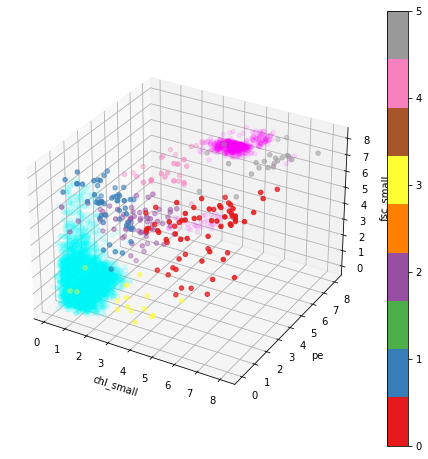

In [7]:
#plot 3D
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

p = ax.scatter3D(non_dense_data['chl_small'], non_dense_data['pe'], non_dense_data['fsc_small'], c=data_labels, cmap='Set1');
ax.scatter3D(dense_data['chl_small'], dense_data['pe'], dense_data['fsc_small'], c=labels_gmm, cmap='cool',alpha=0.1);

ax.set_xlabel('chl_small')
ax.set_ylabel('pe')
ax.set_zlabel('fsc_small')
fig.colorbar(p)

Text(0, 0.5, 'log pe')

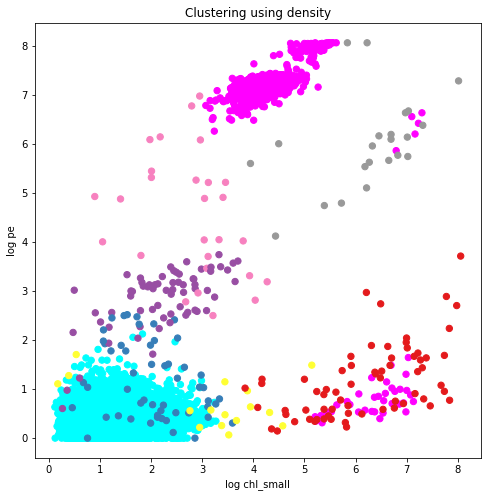

In [8]:
#plot 2D
fig = plt.figure(figsize=(8,8))
plt.scatter(dense_data['chl_small'], dense_data['pe'],40,c=labels_gmm, cmap='cool')
plt.scatter(non_dense_data['chl_small'], non_dense_data['pe'],40,c=data_labels, cmap='Set1')

plt.title('Clustering using density')
plt.xlabel("log chl_small")
plt.ylabel('log pe')

## Changing time using agglomerative

In [28]:
from IPython import display
import time

dense_frac = 0.1
distance_threshold = 17.0

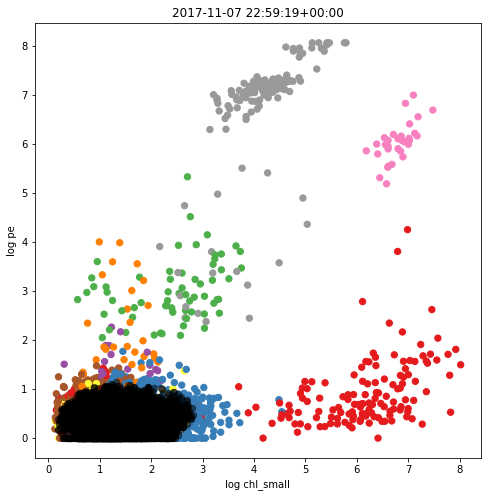

In [32]:
fig = plt.figure(figsize=(8,8))

for i in range(0,len(dates),1):
    fc_dates = fc.loc[fc["date"] == dates[i]]
    data = {'fsc_small': np.log(fc_dates['fsc_small']),
        'pe': np.log(fc_dates['pe']),
        'chl_small':np.log(fc_dates['chl_small'])}
    df = pd.DataFrame(data)
    selected_data = df.iloc[0:10000 , 0:3]
    
    xyz = np.row_stack(([selected_data['fsc_small'], selected_data['pe'],selected_data['chl_small']]))
    z = gaussian_kde(xyz)(xyz)
    dense_data = selected_data[z>dense_frac*z.max()]
    non_dense_data = selected_data.drop(dense_data.index)
    
    #label non-dense data with Agglomerative
    clustering_model = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',compute_full_tree=True, distance_threshold=distance_threshold)
    clustering_model.fit(non_dense_data.iloc[:, 0:3])
    data_labels = clustering_model.labels_

    #label dense data with gmm
    #features=np.stack((dense_data['chl_small'],dense_data['pe'], dense_data['fsc_small']),axis=1);
    #gmm = GaussianMixture(n_components=2)
    #labels_gmm=gmm.fit_predict(features)
    
    #plotting results
    display.display(plt.gcf()); plt.clf()   
    
    
    plt.scatter(non_dense_data['chl_small'], non_dense_data['pe'],40,c=data_labels, cmap='Set1')
    plt.scatter(dense_data['chl_small'], dense_data['pe'],40,c='black',alpha=0.5)
    plt.title(dates[i])
    plt.xlabel("log chl_small")
    plt.ylabel('log pe') 
    
    display.clear_output(wait=True)
    time.sleep(0.01)

## Time changing with gmm

In [128]:
from IPython import display
import time

dense_frac = 0.004
n_clusters = 6
n_points = 20000

init = True

In [135]:
all_labels = np.zeros((n_points,len(dates)))

for i in range(0,len(dates),1):
    fc_dates = fc.loc[fc["date"] == dates[i]]
    data = {'fsc_small': np.log(fc_dates['fsc_small']),
        'pe': np.log(fc_dates['pe']),
        'chl_small':np.log(fc_dates['chl_small'])}
    df = pd.DataFrame(data)
    selected_data = df.iloc[0:n_points , 0:3]
    
    xyz = np.row_stack(([selected_data['fsc_small'], selected_data['pe'],selected_data['chl_small']]))
    z = gaussian_kde(xyz)(xyz)
    dense_data = selected_data[(z>dense_frac*z.max()) & (selected_data['pe']<2) & (selected_data['chl_small']<5)]
    non_dense_data = selected_data.drop(dense_data.index)
    
    #label non-dense data with gmm
    features=np.stack((non_dense_data['chl_small'],non_dense_data['pe'], non_dense_data['fsc_small']),axis=1);
    if init == True:
        gmm = GaussianMixture(n_components=n_clusters)
        init = False
    else:
        gmm = GaussianMixture(n_components=n_clusters, means_init=means)
        
    
    
    labels = gmm.fit_predict(features)
    all_labels[:,i] = np.pad(labels,(0,n_points-len(labels)),mode='constant')
    
    means = gmm.means_

<Figure size 576x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

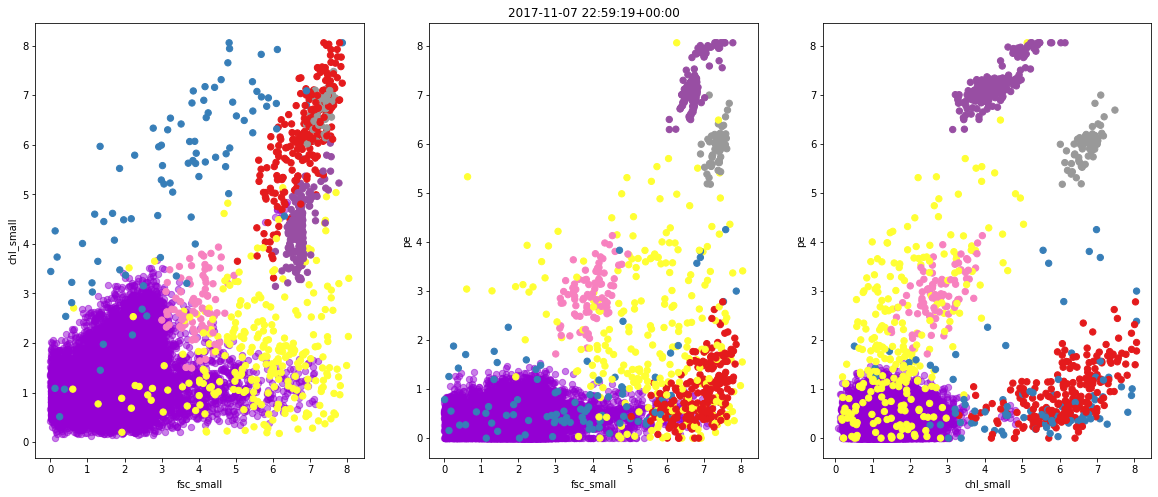

In [137]:
fig = plt.figure(figsize=(8,8))

for i in range(0,len(dates),1):
    fc_dates = fc.loc[fc["date"] == dates[i]]
    data = {'fsc_small': np.log(fc_dates['fsc_small']),
        'pe': np.log(fc_dates['pe']),
        'chl_small':np.log(fc_dates['chl_small'])}
    df = pd.DataFrame(data)
    selected_data = df.iloc[0:n_points , 0:3]
    
    
    
    xyz = np.row_stack(([selected_data['fsc_small'], selected_data['pe'],selected_data['chl_small']]))
    z = gaussian_kde(xyz)(xyz)
    dense_data = selected_data[(z>dense_frac*z.max()) & (selected_data['pe']<2) & (selected_data['chl_small']<5)]
    non_dense_data = selected_data.drop(dense_data.index)
    
    labels = all_labels[0:len(non_dense_data['fsc_small']),i]
    
    display.display(plt.gcf()); plt.clf()   
    fig = plt.figure(figsize=(20,8))
    
    plt.subplot(1,3,1)
    plt.scatter(dense_data['fsc_small'], dense_data['chl_small'],40,c='darkviolet',alpha=0.5)
    plt.scatter(non_dense_data['fsc_small'], non_dense_data['chl_small'],40,c=labels, cmap='Set1')
    plt.xlabel("fsc_small")
    plt.ylabel('chl_small') 
    
    plt.subplot(1,3,2)
    plt.scatter(dense_data['fsc_small'], dense_data['pe'],40,c='darkviolet',alpha=0.5)
    plt.scatter(non_dense_data['fsc_small'], non_dense_data['pe'],40,c=labels, cmap='Set1')
    plt.xlabel("fsc_small")
    plt.ylabel('pe') 
    plt.title(dates[i])
    
    plt.subplot(1,3,3)
    plt.scatter(dense_data['chl_small'], dense_data['pe'],40,c='darkviolet',alpha=0.5)
    plt.scatter(non_dense_data['chl_small'], non_dense_data['pe'],40,c=labels, cmap='Set1')
    plt.xlabel("chl_small")
    plt.ylabel('pe') 
    
    display.clear_output(wait=True)
    time.sleep(0.01)